# Coastal Model Test Bed (CMTB) SWASH 1D Example 

#### This notebook walks through the CMTB SWASH 1D Workflow
    CMTB sets this up as a "skinny" 2D simulation that is effectively 1D
    Notebook users will have to download CMTB from github and install the required python packages
    Users select simulation settings in the User Input Cell and can walk through the rest of the code
    Once CMTB writes the input files, users can run SWASH separately in a command line interface 
    (commands listed at end of notebook) OR, if users have a SWASH mpiexec compiled (aka SWASH compiled in parallel mode),    
    users may run SWASH via CMTB

## Load packages and libraries

In [52]:
import sys
sys.path.insert(0, '/Users/lszcz/Documents/CMTB/cmtb/')

# CMTB 
from prepdata.prepDataLib import PrepDataTools as preptools
from getdatatestbed import getDataFRF
from getdatatestbed.getDataFRF import getDataTestBed
from prepdata import writeRunRead as wrr
from testbedutils import waveLib as sbwave
from subprocess import check_output
from plotting.operationalPlots import generate_CrossShoreTimeseries

# Standard utilities
import datetime as dt
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import netCDF4 as nc4

## User Input Cell: Declare input settings

In [2]:
# Organizational settings
workingDir = '/Users/lszcz/Documents/CMTB/cmtb/data'
exe = '/mirror/swash/swash.exe'
testName = 'swash1D_test_mpi'
versionPrefix='base'   

# Select simulated period
date_str = '2019-10-11' 
startTime = dt.datetime(2019,10,11,15,0,0)          # Start time, Year, month, day, hour
endTime = dt.datetime(2019,10,11,16,0,0)            # Stop time, 1 hour after start time, Year, month, day, hour
simulationDuration = 1                              # length of time for simulated event (should be 1 hour)
spinup = 900                                        # initial spinup time before model output (in seconds)
ncores = 18                                         # number of cores to use

# Select bathymetric setting
bathy_loc = 'survey'
profile_num = 945                                   # FRF profile number
survey_date = dt.datetime(2019, 10, 15, 23)         # Select survey date (always include 23 aka 11 pm to search for any profile collected that day)
xmin = 25                                           # Onshore extent in FRF coordinates
xmax = 915                                          # Offshore extent in FRF coordinates
dx = 1                                              # Resolution in x
dy = 1                                              # Resolution in y 
fric_fac = 0.015

# Select sensor for boundary conditions
sensor = '8m-array'                                 # FRF Sensor used to pull wave conditions

***
***
***

## Auto-format additional variables

In [3]:
runDuration = (endTime - startTime).total_seconds()
ymin = profile_num - dy                                              # Extending selected transect for "Psuedo 1D" simulation, allowing for a skinny alongshore interpolated grid
ymax = profile_num + dy

waveTimeList = preptools.timeLists(startTime,endTime,30*60)          # dt in hours
wlTimeList = preptools.timeLists(startTime+dt.timedelta(minutes=30), # Finds 1 water level halfway through the target event
                                 endTime,30*60)  

## Gather raw data

Waves and water levels

In [4]:
go = getDataFRF.getObs(startTime,endTime)    # initialize go command with simulated period

In [5]:
wave_spec = go.getWaveData(sensor,spec=True) # grab raw spectra
wl = go.getWL()                              # grab raw water levels

https://chldata.erdc.dren.mil/thredds/dodsC/frf/oceanography/waves/8m-array/2019/FRF-ocean_waves_8m-array_201910.nc
https://chldata.erdc.dren.mil/thredds/dodsC/frf/oceanography/waterlevel/eopNoaaTide/2019/FRF-ocean_waterlevel_eopNoaaTide_201910.nc


Bathymetry

In [6]:
gdTB = getDataTestBed(startTime, endTime)    # initialize gdTB command with simulated period

In [7]:
bathy_data = gdTB.getBathyIntegratedTransect(method=1,                     # Gathers relevant data (beyond designated bounds) to pass into prepbathy for interpolation
                                             ForcedSurveyDate=survey_date, 
                                             ybounds=[ymin, ymax])        

!!!Forced bathy date 2019-10-15 23:00:00
https://chldata.erdc.dren.mil/thredds/dodsC/cmtb/integratedBathyProduct/survey/survey.ncml
Bathymetry is taken as closest in HISTORY - operational


Check out raw data

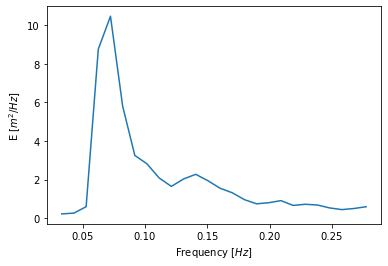

In [8]:
plt.figure()
plt.plot(wave_spec['wavefreqbin'], wave_spec['fspec'])
plt.ylabel('E [$m^2/Hz$]')
plt.xlabel('Frequency [$Hz$]')
plt.show()

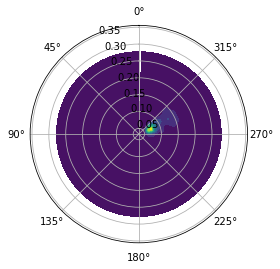

In [9]:
rmesh, thetamesh = np.meshgrid(wave_spec['wavefreqbin'],wave_spec['wavedirbin'])
thetamesh = thetamesh*np.pi/180
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
E_2D_plot = wave_spec['dWED'].T
ax.contourf(np.flip(thetamesh), rmesh,E_2D_plot,10)
ax.set_theta_zero_location("N")
plt.show()

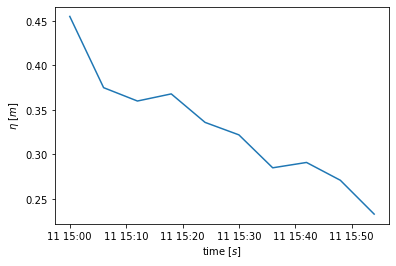

In [10]:
plt.plot(wl['time'], wl['WL'])
plt.ylabel('$\eta$ [$m$]')
plt.xlabel('time [$s$]')
plt.show()

## Format gathered raw data for SWASH input

In [11]:
prepdata = preptools() # initialize prepdata command

Process wave packet

In [12]:
good_freqs = wave_spec['wavefreqbin'][wave_spec['fspec'].mask == False]   
    # Above needed otherwise will interpolated frequencies beyond sensor range, skewing energy levels down to -999
wavePacket = prepdata.prep_spec_phaseResolved(rawspec=wave_spec, 
                                              version_prefix=versionPrefix, 
                                              grid='1D',
                                              spinUpTime=spinup, 
                                              runDuration=runDuration,
                                              freqRange=[min(good_freqs), max(good_freqs)]) # Filter down to "good" frequencies

Process water level packet

In [13]:
wlPacket = prepdata.prep_WL(wl,wlTimeList)
        # Should return 1 record for SWASH input

  -- 1 WL records with 0 interpolated points


Process bathy packet

In [14]:
bathyPacket = prepdata.prep_SwashBathy(x0=xmin, 
                                       y0=profile_num-1, 
                                       bathy=bathy_data, 
                                       xBounds=[xmin, xmax+1], 
                                       yBounds = [ymin,ymax+1], 
                                       dx=dx, dy=dy)
        # if 1D, ybounds should be numbers surrounding target profile number (established in user input cell)
        # Xbounds and Ybounds plus 1 because python is 0-indexed

Check out processed data

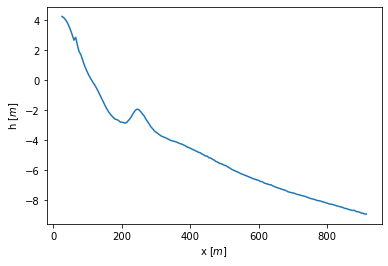

In [15]:
h = bathyPacket['elevation']
h = h[2,:]                          # Identify target profile
plt.figure()
plt.plot(bathyPacket['xFRF'], h)
plt.ylabel('h [$m$]')
plt.xlabel('x [$m$]')
plt.show()

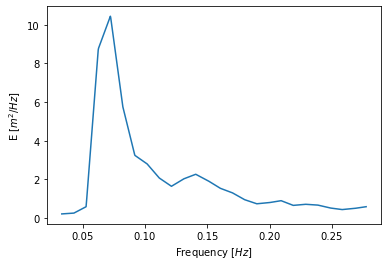

In [16]:
plt.figure()
plt.plot(wavePacket['freqbins'], wavePacket['fspec'])
plt.ylabel('E [$m^2/Hz$]')
plt.xlabel('Frequency [$Hz$]')
plt.show()

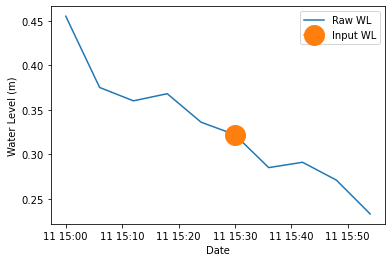

In [17]:
plt.figure()
plt.plot(wl['time'],wl['WL'])
plt.plot(wlPacket['time'],wlPacket['avgWL'],marker="o", markersize=20)
plt.ylabel('Water Level (m)')
plt.xlabel('Date')
plt.legend(('Raw WL','Input WL'))
plt.show()

## Setup the SWASH model

In [18]:
swio = wrr.swashIO(WL=wlPacket['avgWL'], 
                   equilbTime=wavePacket['spinUp'],  
                   Hs=wavePacket['Hs'], 
                   Tp=1/wavePacket['peakf'],
                   Dm=wavePacket['waveDm'],
                   workingDirectory=workingDir, 
                   testName=testName, fileNameBase=date_str,
                   version_prefix=versionPrefix, 
                   runTime=simulationDuration, 
                   startTime=startTime, 
                   endTime=endTime,
                   runFlag=True, 
                   generateFlag=False,
                   readFlag=True)
    # Above initializes swio command

In [19]:
swio._replaceDefaultParams()                    # fill out swio command with default model settings

if not os.path.isdir(swio.workingDirectory):    # make directory where input files stored
    os.makedirs(swio.workingDirectory)
os.chdir(swio.workingDirectory)

swio._check_input()                             # final checks before writing

TODO: Replacing parameters.... whats left can be warned at the end of this process [wrr.swashIO_replaceDefaultParams]
still processing dict_keys([]) from 'modelSettings' in input file


Write the input files

In [20]:
swio.write_spec1D(wavePacket['freqbins'], wavePacket['fspec'])      # writes the SWASH forcing.BND file
swio.write_bot(bathyPacket['elevation'])                            # writes the SWASH bathy.BOT file
swio.write_sws(gridDict=bathyPacket, WLpacket=wlPacket)             # writes the SWASH INPUT.sws file

 TODO: calculate equlib time based on conditions [wrr.writeSWS]


##  -----------------------------------------------------------------------------------------
## (1) User runs SWASH separately: 
    Switch to command line, cd to the directory with input files, and run 'swash INPUT'

## (2) User runs SWASH mpiexec in this notebook: 
    Can be applied if user has SWASH compiled in parallel mode on their machine and can call mpiexec

In [24]:
swio._generateRunStrings(exe)
# overwriting below to account for windows running ubuntu shell on windows machine
swio.runString1 = 'wsl mpiexec -n 18 /mirror/swash/swash.exe INPUT' 

In [64]:
swio._preprocessCheck()
init_t = dt.datetime.now()
print('Running {} Simulation starting at {}'.format(swio.modelName, init_t))

_ = check_output(swio.runstring1, shell=False)            # RUN COMMAND

 TODO: check to make sure all data are in place and in required input dictionaries [wrr.preprocessCheck]
Running swash Simulation starting at 2022-08-31 11:54:23.019465


## -----------------------------------------------------------------------------------------
## Load in results

In [53]:
os.chdir(swio.workingDirectory)                               # add path to results .mat file to directory
[dataDict, metaDict] = swio.loadSwash_Mat(testName+'.mat')    # load in formatted results
    # produces a benign error

 loading SWASH data takes: 2.32 seconds


Calculate some wave statistics

In [54]:
fspec, freqs = sbwave.timeSeriesAnalysis1D(dataDict['time'].squeeze(), dataDict['eta'].squeeze(), bandAvg=6)
Stats = sbwave.stats1D(fspec=fspec, frqbins=freqs, lowFreq=None, highFreq=None)
HsTS = 4 * np.std(dataDict['eta'].squeeze(), axis=0)

/Users/lszcz/Documents/CMTB/cmtb\testbedutils\waveLib.py:492: UserWarning: neglected 1 freq bands (at highest frequency)
  warnings.warn('neglected {} freq bands (at highest frequency)'.format(len(freqW) - max(avgIdxs)))


Check out processed data

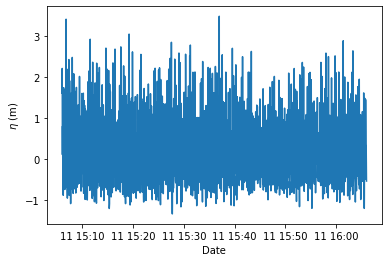

In [55]:
plt.figure()
plt.plot(dataDict['time'],dataDict['eta'][:,0,400])
plt.ylabel('$\eta$ (m)')
plt.xlabel('Date')
plt.show()

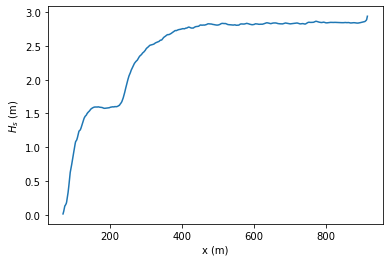

In [56]:
plt.figure()
plt.plot(dataDict['xFRF'],HsTS)
plt.ylabel('$H_s$ (m)')
plt.xlabel('x (m)')
plt.show()

In [61]:
generate_CrossShoreTimeseries(workingDir+'/'+testName+'/img', np.mean(dataDict['eta'].squeeze(), axis=0), dataDict['elevation'], dataDict['xFRF'])

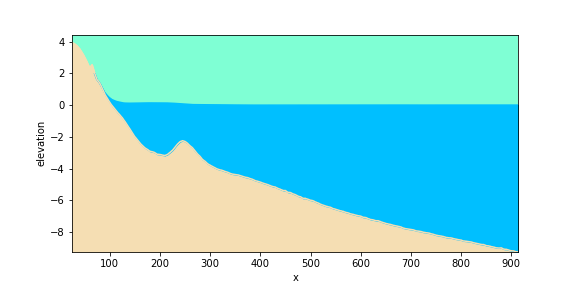

In [63]:
from IPython.display import Image
Image(workingDir+'/'+testName+'/img'+'.png')

## Save Results to netcdf

In [46]:
ncfile = nc4.Dataset('/Users/lszcz/Documents/CMTB/cmtb/data/test4.nc',mode='w')


In [51]:
x_dim = ncfile.createDimension('x', len(dataDict['xFRF']))  
y_dim = ncfile.createDimension('y', len(dataDict['yFRF']))    
time_dim = ncfile.createDimension('time', len(dataDict['time'])) 
eta_dim = ncfile.createDimension('eta', len(dataDict['eta']))


In [50]:
x_dim = ncfile.createDimension('x', len(dataDict['xFRF'])  
y_dim = ncfile.createDimension('y', len(dataDict['yFRF'])    
time_dim = ncfile.createDimension('time', len(dataDict['time']) 
eta_dim = ncfile.createDimension('eta', len(dataDict['eta'])

SyntaxError: invalid syntax (2052290495.py, line 2)

In [48]:
dataDict['xFRF']

array([ 25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
        47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
        58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,
        69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101.,
       102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112.,
       113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123.,
       124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134.,
       135., 136., 137., 138., 139., 140., 141., 142., 143., 144., 145.,
       146., 147., 148., 149., 150., 151., 152., 153., 154., 155., 156.,
       157., 158., 159., 160., 161., 162., 163., 164., 165., 166., 167.,
       168., 169., 170., 171., 172., 173., 174., 17

In [41]:
parms = ncfile.createGroup('dataDict')

In [42]:
for k,v in dataDict.items():
    setattr(parms, k, v)

TypeError: illegal data type for attribute b'time', must be one of dict_keys(['S1', 'i1', 'u1', 'i2', 'u2', 'i4', 'u4', 'i8', 'u8', 'f4', 'f8']), got O

In [43]:
parms


<class 'netCDF4._netCDF4.Group'>
group /dataDict:
    dimensions(sizes): 
    variables(dimensions): 
    groups: 